In [1]:
import os
#import cv2
import math
import mpld3
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from copy import deepcopy
from urllib.request import urlretrieve
# from IPython.display import HTML, display

from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, AngleAxis, Box, 
                         Capsule, ContactResults, Concatenate, DiagramBuilder, LeafSystem,
                         InverseDynamicsController, LoadModelDirectives, MeshcatVisualizer, Parser,
                         PiecewisePolynomial, PiecewisePose, PointCloud, TrajectorySource, 
                         ProcessModelDirectives, RandomGenerator, BasicVector, SceneGraph, 
                         RigidTransform, RollPitchYaw, RotationMatrix, Simulator, StartMeshcat,
                         UniformlyRandomRotationMatrix, Rgba, ContactResults, BaseField, Fields,
                         ConstantVectorSource, FindResourceOrThrow, Integrator, JacobianWrtVariable, 
                         MeshcatVisualizerParams, MultibodyPlant, MultibodyPositionToGeometryPose,
                         Quaternion, JointSliders, Rgba, Sphere, StateInterpolatorWithDiscreteDerivative)
from pydrake.common import FindResourceOrThrow, temp_directory
from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.meshcat import JointSliders
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder

from manipulation import FindResource, running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.clutter import GenerateAntipodalGraspCandidate
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.pick import (MakeGripperCommandTrajectory, MakeGripperFrames,
                               MakeGripperPoseTrajectory)
from manipulation.scenarios import (AddIiwaDifferentialIK, 
                                    MakeManipulationStation, ycb, AddRgbdSensors)

# import torch
# import torch.utils.data
# import torchvision
# import torchvision.transforms.functional as Tf

# from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
# define the model paths
# 1. iiwa and camera
sketchbot_model_path = os.path.abspath("models/sketchbot.dmd.yaml")
camera_model_path = os.path.abspath("models/camera0.dmd.yaml")
# 2. objects
bunny_sdf_path = os.path.abspath("models/bunny.sdf")
bunny_data = f"""
- add_frame:
     name: bunny_origin
     X_PF:
         base_frame: world
         rotation: !Rpy {{ deg: [0.0, 0.0, 0.0 ]}}
         translation: [0, 0, 0.0]

- add_model:
     name: bunny
     file: file://{bunny_sdf_path}
     default_free_body_pose: 
        bunny_link:
            translation: [1.5, 0, 0]
            rotation: !Rpy {{ deg: [90.0, 0.0, -90.0 ]}}

"""
## write the bunny data to a file
with open("models/bunny.dmd.yaml", "w") as f:
    f.write(bunny_data)
bunny_model_path = os.path.abspath("models/bunny.dmd.yaml")
# canvas
canvas_sdf_path = os.path.abspath("models/canvas.sdf")
canvas_data = f"""
- add_model:
    name: canvas
    file: file://{canvas_sdf_path}
    default_free_body_pose: 
        canvas_link:
            translation: [0.5, 0, 0]
            rotation: !Rpy {{ deg: [0.0, -45.0, 0.0 ]}}

- add_weld:
    parent: world
    child: canvas::canvas_top_center
"""
with open("models/canvas.dmd.yaml", "w") as f:
    f.write(canvas_data)
canvas_model_path = os.path.abspath("models/canvas.dmd.yaml")
# chalk
chalk_sdf_path = os.path.abspath("models/chalk.sdf")
chalk_data = f"""
- add_model:
    name: chalk
    file: file://{chalk_sdf_path}

- add_weld:
    parent: wsg::left_finger 
    child: chalk::chalk_link
    X_PC:
        translation: [-0.016, 0.06, 0]
        rotation: !Rpy {{ deg: [90, 0, 0]}}
"""
with open("models/chalk.dmd.yaml", "w") as f:
    f.write(chalk_data)
chalk_model_path = os.path.abspath("models/chalk.dmd.yaml")

def create_scene_data(model_directives_files: list) -> str:
    """Create the scene data for the sketchbot.
       Returns a string containing the scene data.
    """
    model_directives = ""
    for directive in model_directives_files:
        with open(directive, "r") as f:
            model_directives += f.read()
    model_directives += """\n
model_drivers:
    iiwa: !IiwaDriver
        hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""
    return model_directives


sketchbot_directives = create_scene_data([sketchbot_model_path, bunny_model_path, canvas_model_path,chalk_model_path,camera_model_path])
# print(sketchbot_directives)
        
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
class MeshcatWriter(LeafSystem):
    def __init__(self, meshcat, drawing_body_index, canvas_body_index,
                    rgba, line_width=0.01, draw_threshold=0.01):
        LeafSystem.__init__(self)
        self._meshcat = meshcat
        self._drawing_body_index = drawing_body_index
        self._canvas_body_index = canvas_body_index
        self._rgba = rgba
        self._line_width = line_width
        self._draw_threshold = draw_threshold

        self.DeclareAbstractInputPort("contact_results",
                                        AbstractValue.Make(ContactResults()))
        self.DeclarePeriodicDiscreteUpdateEvent(0.01, 0, self.MaybeDraw)

        self._p_WLastDraw_index = self.DeclareDiscreteState(3)
        self._was_in_contact_index = self.DeclareDiscreteState([0])
        self._num_drawn_index = self.DeclareDiscreteState([0])

    def MaybeDraw(self, context, discrete_state):
        results = self.get_input_port().Eval(context)

        # The point on the canvas that most deeply penetrates the chalk.
        p_WDraw = None
        for i in range(results.num_point_pair_contacts()):
            info = results.point_pair_contact_info(i)
            if (info.bodyA_index() == self._drawing_body_index and
                    info.bodyB_index() == self._canvas_body_index):
                p_WDraw = info.point_pair().p_WCb
                break
            elif (info.bodyA_index() == self._drawing_body_index and
                    info.bodyB_index() == self._canvas_body_index):
                p_WDraw = info.point_pair().p_WCa
                break

        if p_WDraw is not None:
            p_WLastDraw = context.get_discrete_state(
                self._p_WLastDraw_index).get_value()
            was_in_contact = context.get_discrete_state(
                self._was_in_contact_index)[0]
            num_drawn = context.get_discrete_state(self._num_drawn_index)[0]
            length = np.linalg.norm(p_WDraw - p_WLastDraw)
            if (was_in_contact and length > self._draw_threshold):
                meshcat.SetObject(f"writer/{num_drawn}",
                                    Capsule(self._line_width, length),
                                    self._rgba)
                p_WMidpoint = (p_WDraw + p_WLastDraw)/2
                X_WCapsule = RigidTransform(
                    RotationMatrix.MakeFromOneVector(
                        p_WDraw - p_WLastDraw, 2), p_WMidpoint)
                meshcat.SetTransform(f"writer/{num_drawn}", X_WCapsule)
                discrete_state.set_value(self._num_drawn_index,
                                            [num_drawn + 1])
                discrete_state.set_value(self._p_WLastDraw_index, p_WDraw)
            elif not was_in_contact:
                discrete_state.set_value(self._p_WLastDraw_index, p_WDraw)

            discrete_state.set_value(self._was_in_contact_index, [1])
        else:
            discrete_state.set_value(self._was_in_contact_index, [0])

In [4]:
#Creating small leaf system that takes a trajectory and provides one pose at a time. 
class PoseSystem(LeafSystem):
    def __init__(self, plant, traj):
        LeafSystem.__init__(self)
        port = self.DeclareAbstractOutputPort("pose", lambda: AbstractValue.Make(RigidTransform()), self.DoCalcOutput)
        self.traj = traj 
    
    def DoCalcOutput(self, context, output):
        """Constructs the output pose based on the trajectory that was passed in."""
        output.set_value(self.traj.GetPose(context.get_time()))

In [5]:
#Pseudoinverse Controller (DiffIK imported through AddIiwaDifferentialIK)
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_G", BasicVector(6))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.DeclareVectorOutputPort("iiwa_velocity", BasicVector(7), self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        V_G = self.V_G_port.Eval(context)
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(self._plant_context, JacobianWrtVariable.kV, self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G) #important
        output.SetFromVector(v)

In [6]:
class TorqueController(LeafSystem):
    """Wrapper System for Commanding Pure Torques to planar iiwa.
    @param plant MultibodyPlant of the simulated plant.
    @param ctrl_fun function object to implement torque control law.
    @param vx Velocity towards the linear direction.
    """

    def __init__(self, plant, ctrl_fun, vx):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()
        self._ctrl_fun = ctrl_fun
        self._vx = vx
        self._joint_indices = [
            plant.GetJointByName(j).position_start()
            for j in ("iiwa_joint_2", "iiwa_joint_4", "iiwa_joint_6")
        ]

        self.DeclareVectorInputPort("iiwa_position_measured", 3)
        self.DeclareVectorInputPort("iiwa_velocity_measured", 3)

        # If we want, we can add this in to do closed-loop force control on z.
        # self.DeclareVectorInputPort("iiwa_torque_external", 3)

        self.DeclareVectorOutputPort(
            "iiwa_position_command", 3, self.CalcPositionOutput
        )
        self.DeclareVectorOutputPort(
            "iiwa_torque_cmd", 3, self.CalcTorqueOutput
        )
        # Compute foward kinematics so we can log the wsg position for grading.
        self.DeclareVectorOutputPort(
            "wsg_position", 3, self.CalcWsgPositionOutput
        )

    def CalcPositionOutput(self, context, output):
        """Set q_d = q_now. This ensures the iiwa goes into pure torque mode in sim by setting the position control torques in InverseDynamicsController to zero.
        NOTE(terry-suh): Do not use this method on hardware or deploy this notebook on hardware.
        We can only simulate pure torque control mode for iiwa on sim.
        """
        q_now = self.get_input_port(0).Eval(context)
        output.SetFromVector(q_now)

    def CalcTorqueOutput(self, context, output):
        # Hard-coded position and force profiles. Can be connected from Trajectory class.
        if context.get_time() < 2.0:
            px_des = 0.65
        else:
            px_des = 0.65 + self._vx * (context.get_time() - 2.0)

        fz_des = 10

        # Read inputs
        q_now = self.get_input_port(0).Eval(context)
        v_now = self.get_input_port(1).Eval(context)
        # tau_now = self.get_input_port(2).Eval(context)

        self._plant.SetPositions(self._plant_context, self._iiwa, q_now)

        # 1. Convert joint space quantities to Cartesian quantities.
        X_now = self._plant.CalcRelativeTransform(
            self._plant_context, self._W, self._G
        )

        rpy_now = RollPitchYaw(X_now.rotation()).vector()
        p_xyz_now = X_now.translation()

        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context,
            JacobianWrtVariable.kQDot,
            self._G,
            [0, 0, 0],
            self._W,
            self._W,
        )

        # Only select relevant terms. We end up with J_G of shape (3,3).
        # Rows correspond to (pitch, x, z).
        # Columns correspond to (q0, q1, q2).
        J_G = J_G[np.ix_([1, 3, 5], self._joint_indices)]
        v_pxz_now = J_G.dot(v_now)

        p_pxz_now = np.array([rpy_now[1], p_xyz_now[0], p_xyz_now[2]])

        # 2. Apply ctrl_fun
        F_pxz = self._ctrl_fun(p_pxz_now, v_pxz_now, px_des, fz_des)

        # 3. Convert back to joint coordinates
        tau_cmd = J_G.T.dot(F_pxz)
        output.SetFromVector(tau_cmd)

    def CalcWsgPositionOutput(self, context, output):
        """
        Compute Forward kinematics. Needed to log the position trajectory for grading.  TODO(russt): Could use MultibodyPlant's body_poses output port for this.
        """
        q_now = self.get_input_port(0).Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q_now)
        X_now = self._plant.CalcRelativeTransform(
            self._plant_context, self._W, self._G
        )

        rpy_now = RollPitchYaw(X_now.rotation()).vector()
        p_xyz_now = X_now.translation()
        p_pxz_now = np.array([rpy_now[1], p_xyz_now[0], p_xyz_now[2]])

        output.SetFromVector(p_pxz_now)

In [7]:
class PoseTrajectorySource(LeafSystem):
    def __init__(self, pose_trajectory):
        LeafSystem.__init__(self)
        self._pose_trajectory = pose_trajectory
        self.DeclareAbstractOutputPort(
            "pose", lambda: AbstractValue.Make(RigidTransform()), self.CalcPose
        )

    def CalcPose(self, context, output):
        output.set_value(self._pose_trajectory.GetPose(context.get_time()))

#Painter Class
class IIWA_Painter():
    def __init__(self, traj1=None, traj2 = None):
        # meshcat.Delete()
        # meshcat.DeleteAddedControls()
        builder = DiagramBuilder()
        
        # set up the system of manipulation stationrio
        scenario = load_scenario(data=sketchbot_directives)
        self.station = builder.AddSystem(
            MakeHardwareStation(scenario, meshcat=meshcat)
        )
        self.plant = self.station.GetSubsystemByName("plant")
        # Remove joint limits from the wrist joint.
        self.plant.GetJointByName("iiwa_joint_7").set_position_limits(
            [-np.inf], [np.inf]
        )
        controller_plant = self.station.GetSubsystemByName(
            "iiwa.controller"
        ).get_multibody_plant_for_control()
        # Export the camera outputs
        builder.ExportOutput(
            self.station.GetOutputPort("camera.rgb_image"), "rgb_image"
        )
        builder.ExportOutput(
            self.station.GetOutputPort("camera.depth_image"), "depth_image"
        )
        # optionally add trajectory source
        if traj1 is not None:
            """ This is the trajectory for the iiwa arm """
            traj_source = builder.AddSystem(PoseTrajectorySource(traj1))
            self.controller = AddIiwaDifferentialIK(
                builder,
                controller_plant,
                frame=controller_plant.GetFrameByName("body"),
            )
            builder.Connect(
                traj_source.get_output_port(),
                self.controller.get_input_port(0),
            )
            builder.Connect(
                self.station.GetOutputPort("iiwa.state_estimated"),
                self.controller.GetInputPort("robot_state"),
            )

            builder.Connect(
                self.controller.get_output_port(),
                self.station.GetInputPort("iiwa.position"),
            )

        wsg_position = builder.AddSystem(ConstantVectorSource([0.001]))
        builder.Connect(
            wsg_position.get_output_port(),
            self.station.GetInputPort("wsg.position"),
        )

        if traj2 is not None:
            """
            This is the gripper trajectory. 
            """
            wsg_position = builder.AddSystem(TrajectorySource(traj2))
            builder.Connect(wsg_position.get_output_port(), self.station.GetInputPort("wsg.position"))
           
        ############## IMPLEMENTING DRAWING ##################
        self.writer = builder.AddSystem(MeshcatWriter(meshcat,
                      self.plant.GetBodyByName("chalk_link").index(),
                      self.plant.GetBodyByName("canvas_link").index(),
                      Rgba(0, 0, 0, 1.0), line_width=0.003))

        builder.Connect(self.station.GetOutputPort("contact_results"), self.writer.get_input_port())
        #####################################################
        
        # Build the diagram
        self.diagram = builder.Build()
        self.gripper_frame = self.plant.GetFrameByName('body')
        self.world_frame = self.plant.world_frame()

        context = self.CreateDefaultContext()
        self.diagram.ForcedPublish(context)
        
        #################### CAMERA STUFF ########################
        depth_im_read = self.diagram.GetOutputPort("depth_image").Eval(context).data.squeeze() #change to camera_context 
        self.depth_im = deepcopy(depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        self.rgb_im = self.diagram.GetOutputPort("rgb_image").Eval(context).data.squeeze()
        # im ratio
        self.im_ratio = self.rgb_im.shape[0], self.rgb_im.shape[1]

        # Get other info about the camera
        self.cam = self.station.GetSubsystemByName("rgbd_sensor_camera")
        cam_context = self.cam.GetMyMutableContextFromRoot(context)
        self.X_WC = self.cam.body_pose_in_world_output_port().Eval(cam_context)
        self.X_WC = RigidTransform(self.X_WC)
        self.cam_info = self.cam.depth_camera_info()

    def visualize_frame(self, name, X_WF, length=0.15, radius=0.006):
        """
        visualize imaginary frame that are not attached to existing bodies

        Input:
            name: the name of the frame (str)
            X_WF: a RigidTransform to from frame F to world.

        Frames whose names already exist will be overwritten by the new frame
        """
        AddMeshcatTriad(
            meshcat, "painter/" + name, length=length, radius=radius, X_PT=X_WF
        )

    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(self.plant, context)

        # provide initial states
        q0 = np.array(
            [
                1.40666193e-05,
                1.56461165e-01,
                -3.82761069e-05,
                -1.32296976e00,
                -6.29097287e-06,
                1.61181157e00,
                -2.66900985e-05,
            ]
        )
        
        # set the joint positions of the kuka arm
        iiwa = self.plant.GetModelInstanceByName("iiwa")
        self.plant.SetPositions(plant_context, iiwa, q0)
        self.plant.SetVelocities(plant_context, iiwa, np.zeros(7))
        wsg = self.plant.GetModelInstanceByName("wsg")
        self.plant.SetPositions(plant_context, wsg, [-0.05,0.05])
        self.plant.SetVelocities(plant_context, wsg, [0, 0])        

        if hasattr(self, 'integrator'):
            self.integrator.set_integral_value(
                self.integrator.GetMyMutableContextFromRoot(context), q0)

        return context

    def get_X_WG(self, context=None):
        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
                    plant_context,
                    frame_A=self.world_frame,
                    frame_B=self.gripper_frame)
        return X_WG

    def paint(self, sim_duration=20.0):
        context = self.CreateDefaultContext()
        simulator = Simulator(self.diagram, context)

        meshcat.StartRecording(set_visualizations_while_recording=False)
        duration = sim_duration if running_as_notebook else 0.01
        simulator.AdvanceTo(duration)
        meshcat.PublishRecording()

    def project_depth_to_pC(self, depth_pixel):
        v = depth_pixel[:,0]
        u = depth_pixel[:,1]
        Z = depth_pixel[:,2]
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u-cx) * Z/fx
        Y = (v-cy) * Z/fy
        pC = np.c_[X,Y,Z]
        return pC
    
    def visualize_key_frames(self, frame_poses):
        for i, pose in enumerate(frame_poses):
            self.visualize_frame('frame_{}'.format(i), pose, length=0.05)

In [8]:
radius = 0.1
p0 = [0.45, 0.0, 0.4]
R0 = RotationMatrix(np.array([[0, 1, 0], [0, 0, -1], [-1, 0, 0]]).T)
rotation = RotationMatrix.MakeYRotation(np.pi / 6.0)
X_WCenter = RigidTransform(R0, p0)

painter = IIWA_Painter()
X_WG = painter.get_X_WG()
painter.visualize_frame('gripper_current', X_WG)

key_frame_poses_in_world = [painter.get_X_WG()]

coordinates = [[0.1090083804456641, 0.0889050324634818], [0.11607309089219019, 0.09135295209454841], [0.12639158929594999, 0.09780783788354075], [0.1304595992619354, 0.11302349668774127], [0.11149866225098856, 0.07908866141617113], [0.11963220273863362, 0.06730275705050928], [0.12734256005182898, 0.05539807985173332], [0.13352186635757085, 0.044776047262871314], [0.13799858320663816, 0.031159445082882032], [0.14270875277899517, 0.020770204645099398], [0.15078801363531125, 0.009491467538236976], [0.13130657464992657, 0.031876782866980986], [0.12126450172989235, 0.041516335295136285], [0.10189729922840866, 0.08605520737831762], [0.08956502472162982, 0.08026850225281146], [0.077139806316771, 0.0751451334020627], [0.08485810492635323, 0.060184504505502105], [0.08996376504679847, 0.04846981951745909], [0.09447515038802828, 0.0374357843487353], [0.09947889379083892, 0.024639107345276672], [0.10441811690932377, 0.01139772050181], [0.109107659980363, -0.00014506207529257155], [0.11671089135459886, -0.012530642488388366], [0.12778828842239556, -0.017620104783416083], [0.1411099866291129, -0.015250333567423923], [0.1504226787996105, -0.005808502335463914], [0.06914993358006563, 0.07522134541225148], [0.05932302788812058, 0.07036408712197863], [0.04988664100880794, 0.06236656039833702], [0.043270061810342667, 0.04900663671613541], [0.039183132583765316, 0.03471896148678729], [0.03825841421148493, 0.020840064774536586], [0.040395597212075925, 0.006545395583388313], [0.04243026483256585, -0.0053568018526300425], [0.04437804033541954, -0.018644725645372433], [0.04562015983553352, -0.031493447372610374], [0.04622338288118908, -0.044197642286075624], [0.046197239802364495, -0.05663225197921167], [0.04403997738683461, -0.07168972006831155], [0.038348889933088576, -0.08632200392542938], [0.030176127169890835, -0.10047407328428529], [0.021299725658402963, -0.11164538456871628], [0.0065866258634590625, -0.12250651738103875], [-0.005299498681799719, -0.1280438185863694], [-0.01554595537074465, -0.1319049249060673], [-0.02578533667395823, -0.13514549954114444], [-0.03616738989520502, -0.13780597252666257], [-0.049572916016316186, -0.14032906238751208], [-0.06263816927205722, -0.14298287841499463], [-0.07024696073564735, -0.14121718975120304], [-0.08193316438230432, -0.13325184376596497], [-0.09634889293929541, -0.1258425615515256], [-0.10791035833329897, -0.1198996327246739], [-0.11866230356359836, -0.1136505295906519], [-0.12817479554606392, -0.1069797748522293], [-0.14056664941856092, -0.09922978100176828], [-0.13896988323281925, -0.11447056785819813], [-0.13403558805940827, -0.12828111375086018], [-0.12702844512966044, -0.1433203318254998], [-0.120911823323401, -0.15374659839631966], [-0.11048443618917031, -0.1655634881847759], [-0.09876707437436653, -0.17170954428970867], [-0.08268182690428455, -0.17359622008285874], [-0.07120322155314261, -0.16348316016454556], [-0.14087134647620678, -0.09708621737440376], [-0.14510091313871432, -0.08273640622953042], [-0.1467041957569179, -0.0689112414546488], [-0.14743936502739644, -0.05557248827721583], [-0.1478795131420004, -0.04247417760955329], [-0.1482409106741404, -0.026728030158367118], [-0.14847400172290076, -0.013459254975218188], [-0.14869622172425376, 0.001010226651211724], [-0.14894519112061994, 0.01711355907588211], [-0.1492523581601031, 0.03478171769794449], [-0.1495559054920652, 0.050208623424130905], [-0.1498606413797586, 0.06375054250853385], [-0.15023392645417688, 0.07703650209818033], [-0.15078801363531114, 0.09197940767062107], [-0.1492243477908121, 0.10599044843692014], [-0.13996442548647292, 0.11413781116614063], [-0.12868401741777996, 0.10627275268534686], [-0.12198094642780495, 0.09376002464667249], [-0.114568697794316, 0.0823059552498279], [-0.10065829551049535, 0.08161838938742005], [-0.09462770142771354, 0.09067934156832314], [-0.0909259063525485, 0.10456667727736033], [-0.08450586581860842, 0.11722255799624452], [-0.07411433033381036, 0.1314902312589577], [-0.0633200299076625, 0.14369665971998496], [-0.05283053233522253, 0.152247722818885], [-0.03888443319813439, 0.1565674740589741], [-0.02456874307737064, 0.15781387506359146], [-0.010725739167587449, 0.15682753579824488], [0.005087048761111192, 0.15331574761104844], [0.013072396800716092, 0.16156899479926926], [0.021840270365208313, 0.17269340649664924], [0.03689708165542925, 0.17359622008285874], [0.04833050631589708, 0.1703361273748368], [0.061048955607853374, 0.16672759252246908], [0.07491298945749213, 0.16430916533009657], [0.08682496001536322, 0.16026910592936383], [0.09443420691136475, 0.14948464488850835], [0.09926708264134482, 0.13610935477316696], [0.10779183270563704, 0.12553582603287441], [0.12174284161175285, 0.12024712730982072], [0.10293751698794472, 0.12034754294670484], [0.10422985177063242, 0.1054788020970774], [0.00947709309719528, 0.13823731525078892], [0.012601967558637966, 0.1274826041461546], [0.017553161026877775, 0.1163306647454217], [0.02752399455327361, 0.10899312523315587], [0.043728770637871665, 0.10995362287178148], [0.058521735143603454, 0.11008875125707335], [0.04772366477414846, 0.06049722047492253], [0.0358157872930816, 0.07098636745543876], [0.03040657758270936, 0.08058613958000899], [0.026740650844472726, 0.09061680618602418], [0.024712543922007627, 0.09902738241187126], [-0.008500025941540116, -0.05324182714382039], [-0.012673122424002486, -0.03476899430218009], [-0.0147386519985522, -0.02336876426852166], [-0.017066807023093135, -0.012287311607110383], [-0.02047095218798836, 0.0009871928341053718], [-0.02699457499654909, 0.01548703444002763], [-0.03698676070904719, 0.022459157071202412], [-0.05426549280759162, 0.023955542334026633], [-0.06500942535591207, 0.022178829946498356], [-0.07886476527989339, 0.01850026257159186], [-0.09420510304768868, 0.016457289507088264], [-0.1104832155281623, 0.01645448345076318], [-0.12132868102725797, 0.00881292375409953], [-0.1229472171412483, -0.00499219592597251], [-0.12381556255191686, -0.018093873844784752], [-0.12438829543990232, -0.031698562437036684], [-0.12472701368457945, -0.045864495179396156], [-0.12414038519664905, -0.05949649887370845], [-0.1213290377233709, -0.073000199119998], [-0.1177203075139181, 0.020675115747059068], [-0.12148750899863717, 0.03279234406154308], [-0.1290746958770818, 0.0396075944831581], [0.11085159378498428, 0.0261605999035055], [0.11056076982420336, 0.0403237861761877], [0.11122763215243879, 0.012778975927996953], [0.12077432966358742, 0.09379529408762995], [0.1110111504053922, 0.07982119114631826], [0.11896374174630887, 0.06826440012176534], [0.12707629432519413, 0.05583275360737207], [0.13321905160977132, 0.045328063080132326], [0.13801136452957177, 0.03121584624300897], [0.14253874401653924, 0.02101225300047315], [0.15069135467346054, 0.009618335841559997], [0.13185591590579668, 0.03143817568167458], [0.1216410535046041, 0.04113707316786486], [0.10189729922840866, 0.08605520737831762], [0.08956502472162982, 0.08026850225281146], [0.077139806316771, 0.0751451334020627], [0.08485810492635323, 0.060184504505502105], [0.08996376504679847, 0.04846981951745909], [0.09447515038802828, 0.0374357843487353], [0.09947889379083892, 0.024639107345276672], [0.10441811690932377, 0.01139772050181], [0.109107659980363, -0.00014506207529257155], [0.11671089135459886, -0.012530642488388366], [0.12778828842239556, -0.017620104783416083], [0.1411099866291129, -0.015250333567423923], [0.1504226787996105, -0.005808502335463914], [0.06914993358006563, 0.07522134541225148], [0.05932302788812058, 0.07036408712197863], [0.04988664100880794, 0.06236656039833702], [0.043270061810342667, 0.04900663671613541], [0.039183132583765316, 0.03471896148678729], [0.03825841421148493, 0.020840064774536586], [0.040395597212075925, 0.006545395583388313], [0.04243026483256585, -0.0053568018526300425], [0.04437804033541954, -0.018644725645372433], [0.04562015983553352, -0.031493447372610374], [0.04622338288118908, -0.044197642286075624], [0.046197239802364495, -0.05663225197921167], [0.04403997738683461, -0.07168972006831155], [0.038348889933088576, -0.08632200392542938], [0.030176127169890835, -0.10047407328428529], [0.021299725658402963, -0.11164538456871628], [0.0065866258634590625, -0.12250651738103875], [-0.005299498681799719, -0.1280438185863694], [-0.01554595537074465, -0.1319049249060673], [-0.02578533667395823, -0.13514549954114444], [-0.03616738989520502, -0.13780597252666257], [-0.049572916016316186, -0.14032906238751208], [-0.06263816927205722, -0.14298287841499463], [-0.07024696073564735, -0.14121718975120304], [-0.08193316438230432, -0.13325184376596497], [-0.09634889293929541, -0.1258425615515256], [-0.10791035833329897, -0.1198996327246739], [-0.11866230356359836, -0.1136505295906519], [-0.12817479554606392, -0.1069797748522293], [-0.14056664941856092, -0.09922978100176828], [-0.13896988323281925, -0.11447056785819813], [-0.13403558805940827, -0.12828111375086018], [-0.12702844512966044, -0.1433203318254998], [-0.120911823323401, -0.15374659839631966], [-0.11048443618917031, -0.1655634881847759], [-0.09876707437436653, -0.17170954428970867], [-0.08268182690428455, -0.17359622008285874], [-0.07120322155314261, -0.16348316016454556], [-0.14087134647620678, -0.09708621737440376], [-0.14510091313871432, -0.08273640622953042], [-0.1467041957569179, -0.0689112414546488], [-0.14743936502739644, -0.05557248827721583], [-0.1478795131420004, -0.04247417760955329], [-0.1482409106741404, -0.026728030158367118], [-0.14847400172290076, -0.013459254975218188], [-0.14869622172425376, 0.001010226651211724], [-0.14894519112061994, 0.01711355907588211], [-0.1492523581601031, 0.03478171769794449], [-0.1495559054920652, 0.050208623424130905], [-0.1498606413797586, 0.06375054250853385], [-0.15023392645417688, 0.07703650209818033], [-0.15078801363531114, 0.09197940767062107], [-0.1492243477908121, 0.10599044843692014], [-0.13996442548647292, 0.11413781116614063], [-0.12868401741777996, 0.10627275268534686], [-0.12198094642780495, 0.09376002464667249], [-0.114568697794316, 0.0823059552498279], [-0.10065829551049535, 0.08161838938742005], [-0.09462770142771354, 0.09067934156832314], [-0.0909259063525485, 0.10456667727736033], [-0.08450586581860842, 0.11722255799624452], [-0.07411433033381036, 0.1314902312589577], [-0.0633200299076625, 0.14369665971998496], [-0.05283053233522253, 0.152247722818885], [-0.03888443319813439, 0.1565674740589741], [-0.02456874307737064, 0.15781387506359146], [-0.010725739167587449, 0.15682753579824488], [0.005087048761111192, 0.15331574761104844], [0.013072396800716092, 0.16156899479926926], [0.021840270365208313, 0.17269340649664924], [0.03689708165542925, 0.17359622008285874], [0.04833050631589708, 0.1703361273748368], [0.061048955607853374, 0.16672759252246908], [0.07491298945749213, 0.16430916533009657], [0.08682496001536322, 0.16026910592936383], [0.09443420691136475, 0.14948464488850835], [0.09926708264134482, 0.13610935477316696], [0.10779183270563704, 0.12553582603287441], [0.12174284161175285, 0.12024712730982072], [0.10293751698794472, 0.12034754294670484], [0.10422985177063242, 0.1054788020970774], [0.00947709309719528, 0.13823731525078892], [0.012601967558637966, 0.1274826041461546], [0.017553161026877775, 0.1163306647454217], [0.02752399455327361, 0.10899312523315587], [0.043728770637871665, 0.10995362287178148], [0.058521735143603454, 0.11008875125707335], [0.04637632105336343, 0.06111153162932783], [0.03503957170502861, 0.07214869896133962], [0.029936024669355903, 0.08162724526512875], [0.026475809959276262, 0.0916462174660577], [0.024526737545624542, 0.0998078620655723], [0.12942132598586353, 0.10146122151374891], [-0.11178465933117616, 0.016488697204856864], [-0.09589288604275419, 0.0163754855625823], [-0.0801095841342975, 0.018229986647026523], [-0.06611422710400507, 0.021924934234940453], [-0.05529592119517088, 0.023848329771695945], [-0.03830672075641519, 0.02288544958943328], [-0.0279622043329681, 0.016615773245843457], [-0.020997264077063052, 0.0027330201188060527], [-0.017352691132271048, -0.011046795111068037], [-0.014950361647864839, -0.02227854631978255], [-0.01291140676444502, -0.033440696408031156], [-0.010629741522871883, -0.04535375695980997], [-0.11776552356095113, 0.016097734420905795], [-0.12231877093336811, 0.001699649737919799], [-0.12340656460182242, -0.011214346753611836], [-0.12411703993419804, -0.02445905305646386], [-0.12456235666303132, -0.03742213476562074], [-0.12468647492219487, -0.053123153091605445], [-0.12297964832225466, -0.06626536847403282], [-0.11977987270710355, -0.07888635523349422], [-0.1186516174858847, 0.027460308422105072], [-0.12489348297354684, 0.03652634432195612], [-0.1349677238196091, 0.04226536088612284], [0.11098769347015207, 0.019665997416581718], [0.1107412867874482, 0.03272957489080216]]

for coordinate in coordinates:
    
    #Rot_m = RotationMatrix.MakeYRotation(rotation)

    #translate the x coordinate 0.5 units up to be centered on the canvas
    pose = [coordinate[0] + 0.5, coordinate[1], 0.175+0.015] 
    # print(pose)

    this_pose = RigidTransform(X_WCenter.rotation().multiply(rotation), pose)
    key_frame_poses_in_world.append(this_pose)

def visualize_key_frames(frame_poses):
    for i, pose in enumerate(frame_poses):
        painter.visualize_frame("frame_{}".format(i), pose, length=0.05)


#key_frame_poses = compose_circular_key_frames(
#    thetas, X_WCenter, painter.get_X_WG()
#)
visualize_key_frames(key_frame_poses_in_world)

total_time = 20
times = np.linspace(0, total_time, len(key_frame_poses_in_world))
traj = PiecewisePose.MakeLinear(times, key_frame_poses_in_world)

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



In [9]:
#writing the gripper trajectories: 
gripper_knots = 0.001*np.ones(len(key_frame_poses_in_world)).reshape(1,len(key_frame_poses_in_world))
wsg_traj = PiecewisePolynomial.FirstOrderHold(times, gripper_knots)

painter = IIWA_Painter(traj)
painter.paint(sim_duration=total_time)

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



(480, 640)


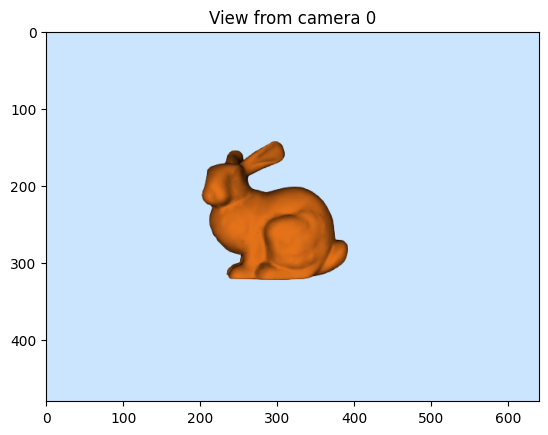

In [10]:
from PIL import Image
print(painter.im_ratio)
plt.imshow(painter.rgb_im)
plt.title("View from camera 0")
plt.show()